In [1]:
!pip install pmdarima
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 2.1MB 48.8MB/s 
     |████████████████████████████████| 9.5MB 37.2MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
df = pd.read_csv("Retail_Sales_Beer_Liquor.csv", index_col= 'DATE', parse_dates=True)

In [3]:
df.head()

,MRTSSM4453USN
DATE,
1992-01-01,1509
1992-02-01,1541
1992-03-01,1597
1992-04-01,1675
1992-05-01,1822


In [4]:
df.columns = ['Sales']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1992-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [6]:
df.describe()

,Sales
count,324.000000
mean,2972.895062
std,1010.218574
min,1501.000000
25%,2109.000000
50%,2791.000000
75%,3627.250000
max,6370.000000


In [7]:
df.isna().sum()

Sales    0
dtype: int64

The data has no Null Values 


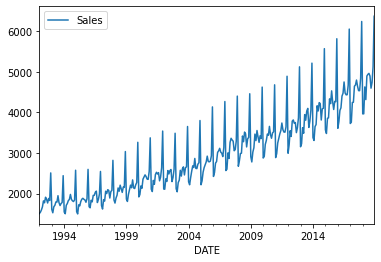

In [8]:
df.plot()

From the plot we can see a A positive trend in the data. And also there is a yearly seasonality in the data.

Let's do a Seasonal Decomposition to plot out the various attrubutes of the data

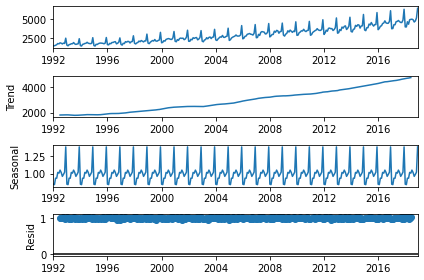

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
mul = seasonal_decompose(df, model = 'multiplicative')
x= mul.plot()

The plot revelas a Seasonality trend is there in the data. We can aslo clearly see that the series is not stationary but we will run a Dickey_fuller test just to be sure

In [10]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df,autolag = 'AIC')
print(f'ADF Statistics: {adf[0]}')
print(f'p-Value: {adf[1]}')

for key,value in adf[4].items():
  print('Critical Value')
  print(f'{key}, {value}')

ADF Statistics: 2.864308507897259
p-Value: 1.0
Critical Value
1%, -3.45176116018037
Critical Value
5%, -2.870970093607691
Critical Value
10%, -2.571794416006072


A p-value greater than 0.05 i.e. p>0.05 indicates that the data is non-stationary and thus we do not reject the null hypothesis.

Lets Do Differencing to make the series stationary
# Differencing

In [11]:
df['First Differencing'] = df['Sales'] - df['Sales'].shift()
df['Seasonal Differencing'] = df['Sales'] - df['Sales'].shift(12)

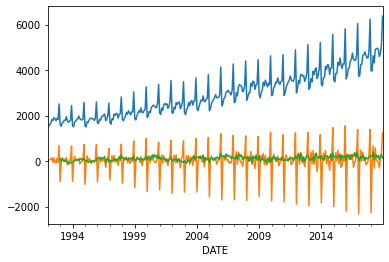

In [12]:
df['Sales'].plot()
df['First Differencing'].plot()
df['Seasonal Differencing'].plot()

Doing a first order differencing makes our series very much stationary 
Therefore we will set d=1;

In [13]:
#Checking Stationarity with Dickey Fuller test
result = adfuller(df['First Differencing'].dropna(),autolag = 'AIC')
print(f'ADF Statistics: {result[0]}')
print(f'p-Value: {result[1]}')

for key,value in result[4].items():
  print('Critical Value')
  print(f'{key}, {value}')

ADF Statistics: -4.033255052422641
p-Value: 0.0012460469107307003
Critical Value
1%, -3.45169128009473
Critical Value
5%, -2.8709394227049154
Critical Value
10%, -2.5717780602423517


A p-value<0.05 tells us that the series is stationary, and hence we reject the null hypothesis

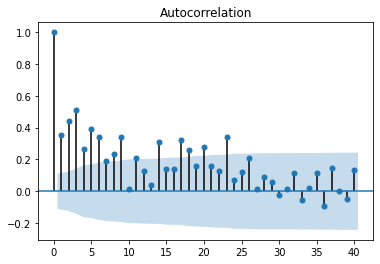

In [19]:
#ACF and PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
#To find the q value for the model we plot the ACF plot
MA_term = plot_acf(df['Seasonal Differencing'].dropna(),lags=40)

For the MA model we see a repeated patter after MA = 3. so we will set q =3 for our model.

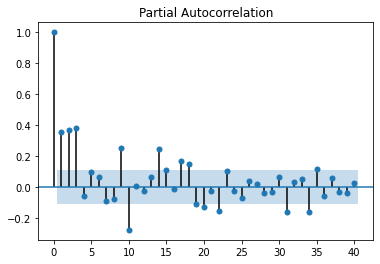

In [20]:
#CHecking for AR(p) term using PACF
AR_term = plot_pacf(df['Seasonal Differencing'].dropna(), lags=40)

looking at the plot we can see that the Partial Autocorelation shuts off after 4, So we can choose p=4 as our value for the model.

# ARIMA

Since our model is showing seasonality we need to find the seasonal parameters to make an effective model.
Lets run and auto_arima model to check weather our predicted values for p,d,q are actually correct.

In [21]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
model = pm.auto_arima(df['Sales'], seasonal = True, m=12,
                      stepwise=True )
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  324
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1774.507
Date:                              Fri, 22 Jan 2021   AIC                           3571.014
Time:                                      17:44:13   BIC                           3612.152
Sample:                                           0   HQIC                          3587.458
                                              - 324                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0121      0.087    -11.571      0.000      -1.184      -0.841
ar.L2         -0.5398      0.157     -3.431      0.001      -0.848      -0.231
ar.L3          0.4817      0.157      3.071      0.002       0.174       0.789
ar.L4          0.2924      0.087      3.351      0.001       0.121       0.463
ma.L1          0.2133      0.062      3.427      0.001       0.091       0.335
ma.L2         -0.0403      0.063     -0.639      0.523      -0.164       0.083
ma.L3         -0.8788      0.049    -17.866      0.000      -0.975      -0.782
ar.S.L12      -1.0078      0.402     -2.505      0.012      -1.796      -0.219
ar.S.L24      -0.2326      0.088     -2.656      0.008      -0.404      -0.061
ma.S.L12       0.7550      0.402      1.880      0.060      -0.032       1.542
sigma2      5809.2942    504.098     11.524      0.000    4821.280    6797.308
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.57   Prob(JB):                         0.48
Heteroskedasticity (H):               2.06   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The auto_arima models gives out the values that we have predicted for the ARIMA model along with the seasonal parameters. Lets train the model on these values

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
model = SARIMAX(df['Sales'], order = (4,1,3), seasonal_order=(2,1,1,12))
result = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [24]:
df.shape

(324, 3)

In [26]:
train = df[:300]
test = df[301:]

start=len(train)
end=len(train)+len(test)-1

In [27]:
df['forecast'] = result.predict(start = start, end = end, dynamic = True )

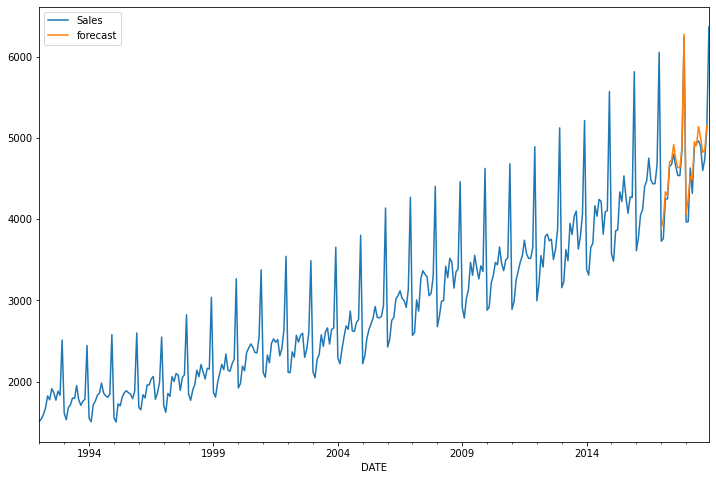

In [28]:
df[['Sales', 'forecast']].plot(figsize=(12,8))

Forecasting in the future:


In [29]:
FutureForecast = result.predict(start = len(df), end = len(df) + 20, dynamic = True )

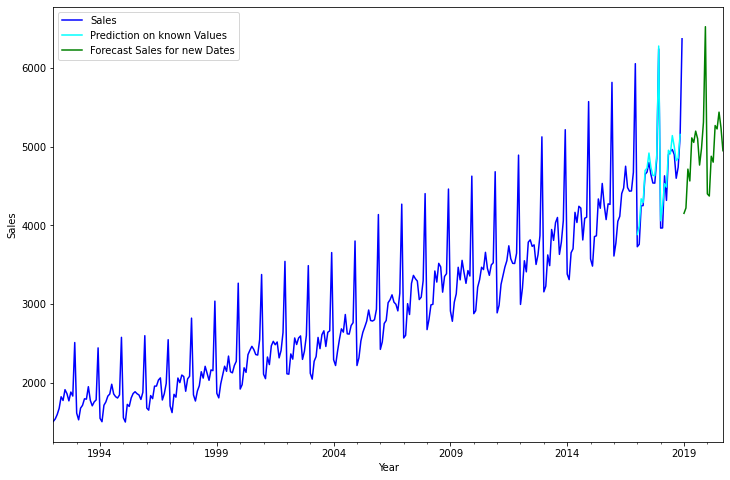

In [47]:
plt.figure(figsize=(12,8))
df['Sales'].plot(color = 'blue')
df['forecast'].plot(label = 'Prediction on known Values', color = 'cyan')
FutureForecast.plot(label = 'Forecast Sales for new Dates', color = 'green')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()


From the plot we can see that we are able to capture the seasonality pretty good with the SARIMA model.